In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import pylab as mplot
import yaml
import h5py
import scipy.optimize
import tqdm
from pylab import cm
#import healpy as hp
import os
import fitsio

In [22]:
import matplotlib.pyplot as plt

dpi = 300
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['lines.markersize'] = 3
plt.rc('lines', dotted_pattern = [2., 2.]) # this makes lines plotted by plt.grid much nicer looking

#if you don't have LaTeX installed on your laptop and this statement 
# generates error, comment it out
#plt.rc('text', usetex=True)

In [8]:
fnames = []
for i in os.listdir('/project/chihway/data/decade/shearcat_v2'):
    if i.startswith('metacal'):
        fnames.append(i)
print(len(fnames))

2962


In [4]:
corners = np.loadtxt('/project2/chihway/dhayaa/FocalPlaneCoordOffsets.txt')

## Calibrate for Response

In [9]:
def mask_default(cat):
    mask0_default = (~((cat['mcal_T_noshear'][:]>2)*(cat['mcal_s2n_noshear'][:]<30)))*(cat['mcal_T_noshear'][:]<10)*(cat['mcal_s2n_noshear'][:]<1000)*(cat['mcal_s2n_noshear'][:]>10)*(cat['mcal_T_ratio_noshear'][:]>0.5)
    mask_1p_default = (~((cat['mcal_T_1p'][:]>2)*(cat['mcal_s2n_1p'][:]<30)))*(cat['mcal_T_1p'][:]<10)*(cat['mcal_s2n_1p'][:]<1000)*(cat['mcal_s2n_1p'][:]>10)*(cat['mcal_T_ratio_1p'][:]>0.5)
    mask_1m_default = (~((cat['mcal_T_1m'][:]>2)*(cat['mcal_s2n_1m'][:]<30)))*(cat['mcal_T_1m'][:]<10)*(cat['mcal_s2n_1m'][:]<1000)*(cat['mcal_s2n_1m'][:]>10)*(cat['mcal_T_ratio_1m'][:]>0.5)
    mask_2p_default = (~((cat['mcal_T_2p'][:]>2)*(cat['mcal_s2n_2p'][:]<30)))*(cat['mcal_T_2p'][:]<10)*(cat['mcal_s2n_2p'][:]<1000)*(cat['mcal_s2n_2p'][:]>10)*(cat['mcal_T_ratio_2p'][:]>0.5)
    mask_2m_default = (~((cat['mcal_T_2m'][:]>2)*(cat['mcal_s2n_2m'][:]<30)))*(cat['mcal_T_2m'][:]<10)*(cat['mcal_s2n_2m'][:]<1000)*(cat['mcal_s2n_2m'][:]>10)*(cat['mcal_T_ratio_2m'][:]>0.5)

    return mask0_default, mask_1p_default, mask_1m_default, mask_2p_default, mask_2m_default

In [13]:
dgamma = 2*0.01

g1p = 0.
g1m = 0.
g2p = 0.
g2m = 0.
gs1p = 0.
gs1m = 0.
gs2p = 0.
gs2m = 0.

count0 = 0.
count1p = 0.
count1m = 0.
count2p = 0.
count2m = 0.

unreadable = []
for fname in tqdm.tqdm(fnames): 
    try: 
        new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname}')
    except: 
        unreadable.append(fname)
        continue
    
    df0, df1p, df1m, df2p, df2m = mask_default(new)
    
    count0 += np.sum(df0)
    count1p += np.sum(df1p)
    count1m += np.sum(df1m)
    count2p += np.sum(df2p)
    count2m += np.sum(df2m)
    
    g1p += np.sum(new['mcal_g_1p'][:,0][df0])
    g1m += np.sum(new['mcal_g_1m'][:,0][df0])
    g2p += np.sum(new['mcal_g_2p'][:,1][df0])
    g2m += np.sum(new['mcal_g_2m'][:,1][df0])
    
    gs1p += np.sum(new['mcal_g_noshear'][:,0][df1p])
    gs1m += np.sum(new['mcal_g_noshear'][:,0][df1m])
    gs2p += np.sum(new['mcal_g_noshear'][:,1][df2p])
    gs2m += np.sum(new['mcal_g_noshear'][:,1][df2m])
    
R11 = (g1p/count0 - g1m/count0)/dgamma
R11s = (gs1p/count1p - gs1m/count1m)/dgamma
R22 = (g2p/count0 - g2m/count0)/dgamma
R22s = (gs2p/count2p - gs2m/count2m)/dgamma
R11tot = R11+R11s
R22tot = R22+R22s

100%|███████████████████████████████████████████████████████████████████████████████| 2962/2962 [26:09<00:00,  1.89it/s]


In [14]:
unreadable

['metacal_output_DES0831-2041.fits',
 'metacal_output_DES1105+2417.fits',
 'metacal_output_DES1107+1252.fits',
 'metacal_output_DES0856-2415.fits',
 'metacal_output_DES0828+1543.fits',
 'metacal_output_DES0946-0707.fits',
 'metacal_output_DES0747+1043.fits']

In [15]:
readable = []
for fname in fnames: 
    if fname not in unreadable:
        readable.append(fname)

In [16]:
R11tot, R22tot

(0.7072887444170503, 0.7082566355185919)

In [17]:
nbinx = 130
nbiny = 140
xbin = np.linspace(1,26625,nbinx+1) # 12*2048+2048+1
ybin = np.linspace(1,28673,nbiny+1) # 6*4096+4096+1
shear1 = np.zeros((nbiny,nbinx))
shear2 = np.zeros((nbiny,nbinx))
count = np.zeros((nbiny,nbinx))

for fname in tqdm.tqdm(readable): 
    new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname}')
    df0, df1p, df1m, df2p, df2m = mask_default(new)
    
    e1_s = new['mcal_g_noshear'][df0][:,0]/R11tot
    e2_s = new['mcal_g_noshear'][df0][:,1]/R22tot

    ccdnum_s = new['ccdnum'][df0]
    x_exp_s = new['x_exp'][df0]
    y_exp_s = new['y_exp'][df0]

    e1_s = np.reshape(e1_s,(len(ccdnum_s),1,1))*np.ones(np.shape(ccdnum_s))
    e2_s = np.reshape(e2_s,(len(ccdnum_s),1,1))*np.ones(np.shape(ccdnum_s))

    x_focal_s = -9999.*np.ones_like(ccdnum_s)
    y_focal_s = -9999.*np.ones_like(ccdnum_s)


    for i in range(0,3):
        for j in range(0,20):
            coordmask = ccdnum_s[:,i,j]!=-9999

            offset_x, offset_y = corners[:,ccdnum_s[coordmask,i,j]]
            x_focal_s[coordmask,i,j] = offset_x + x_exp_s[coordmask,i,j]
            y_focal_s[coordmask,i,j] = offset_y + y_exp_s[coordmask,i,j]

            ind_x = np.digitize(x_focal_s[coordmask,i,j],xbin)-1
            ind_y = np.digitize(y_focal_s[coordmask,i,j],ybin)-1
            ind_a = nbiny*ind_x+ind_y # 2d bin index --> 1d bin index

            e1 = np.bincount(ind_a,e1_s[coordmask,i,j],minlength=nbinx*nbiny) 
            e2 = np.bincount(ind_a,e2_s[coordmask,i,j],minlength=nbinx*nbiny)
            N = np.bincount(ind_a,minlength=nbinx*nbiny)

            categories = np.arange(nbinx*nbiny)
            ind_x = categories//nbiny
            ind_y = categories%nbiny

            count[ind_y,ind_x] += N
            shear1[ind_y,ind_x] += e1
            shear2[ind_y,ind_x] += e2
count[-1,-1]=np.nan

100%|███████████████████████████████████████████████████████████████████████████████| 2955/2955 [32:39<00:00,  1.51it/s]


In [31]:
len(fnames)

2962

In [27]:
Ncount = np.where(count<10000,0,count)

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'y')

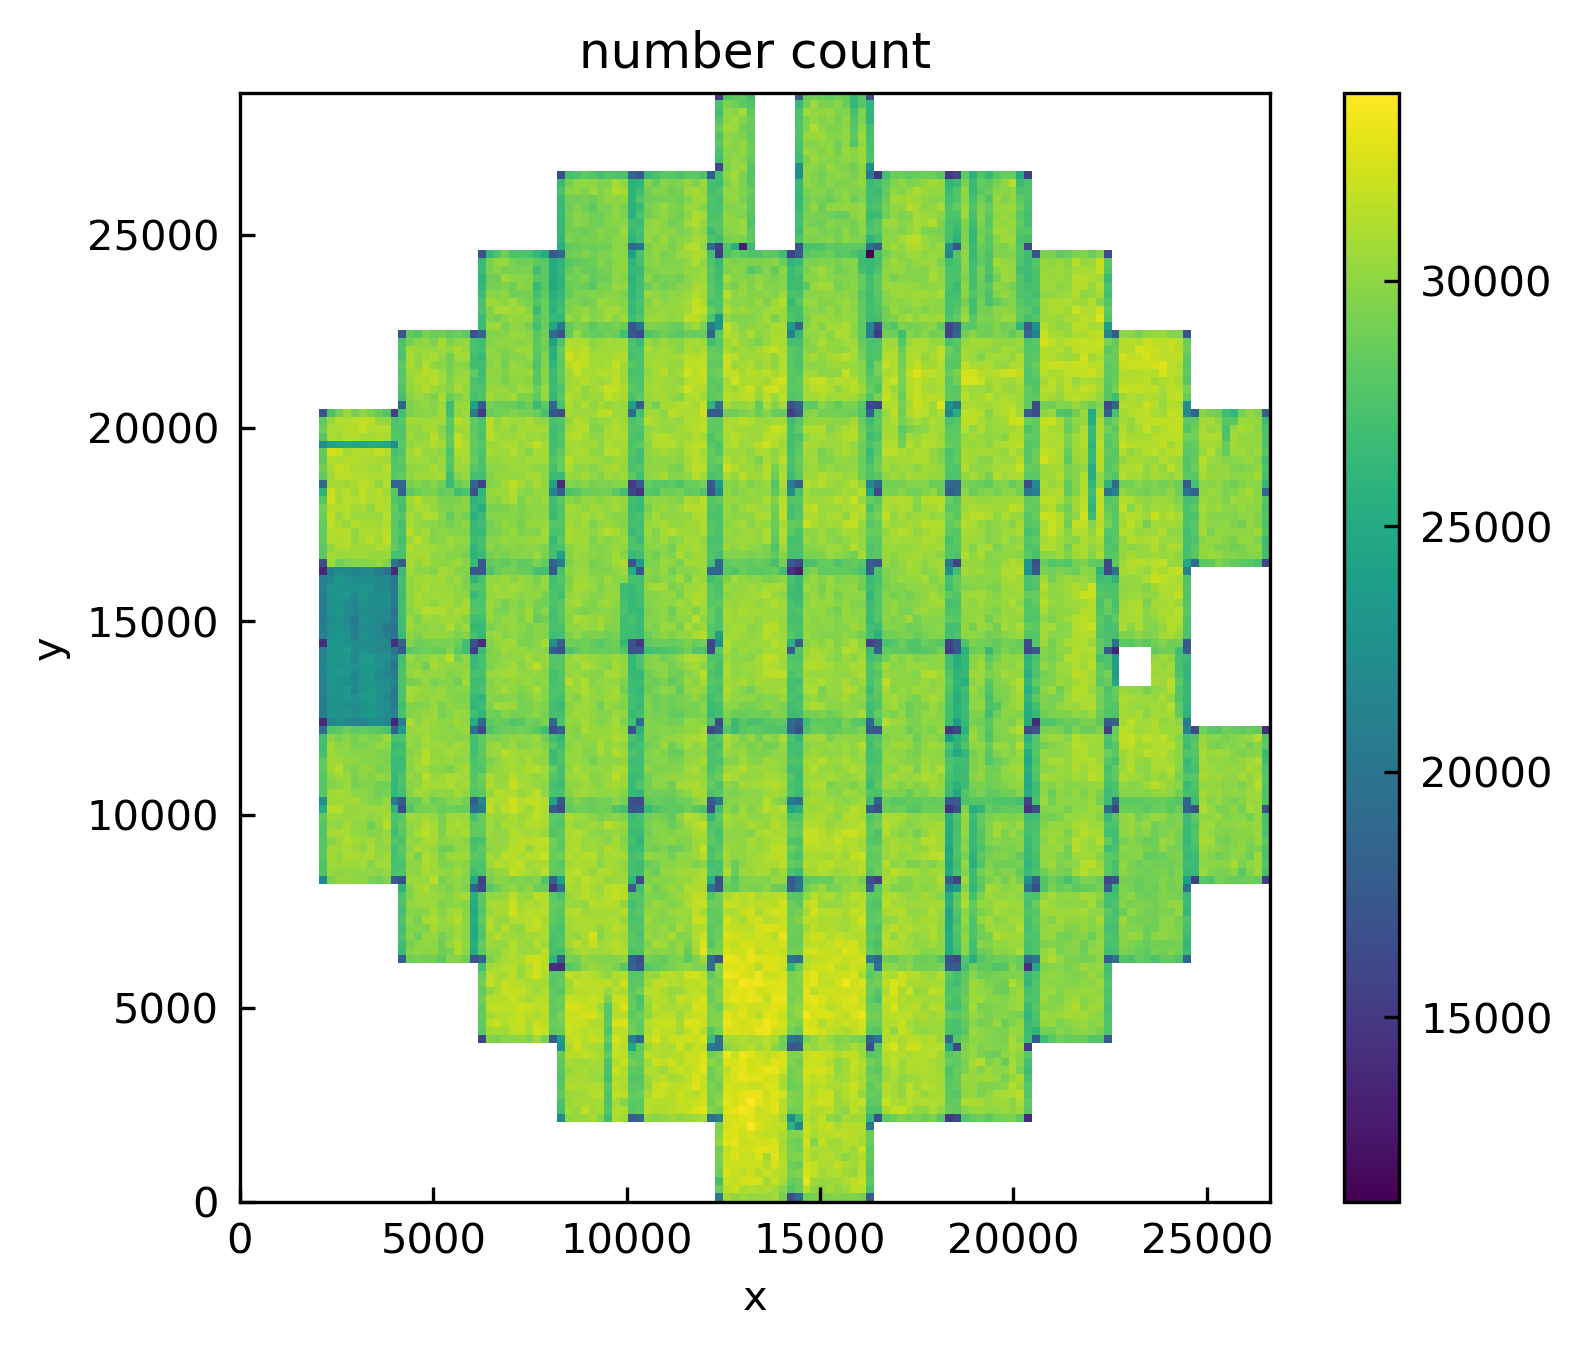

In [28]:
plt.imshow(Ncount**2/Ncount,origin='lower',extent=[0,26625,0,28673])
plt.colorbar()
plt.title('number count')
plt.xlabel('x')
plt.ylabel('y')

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'y')

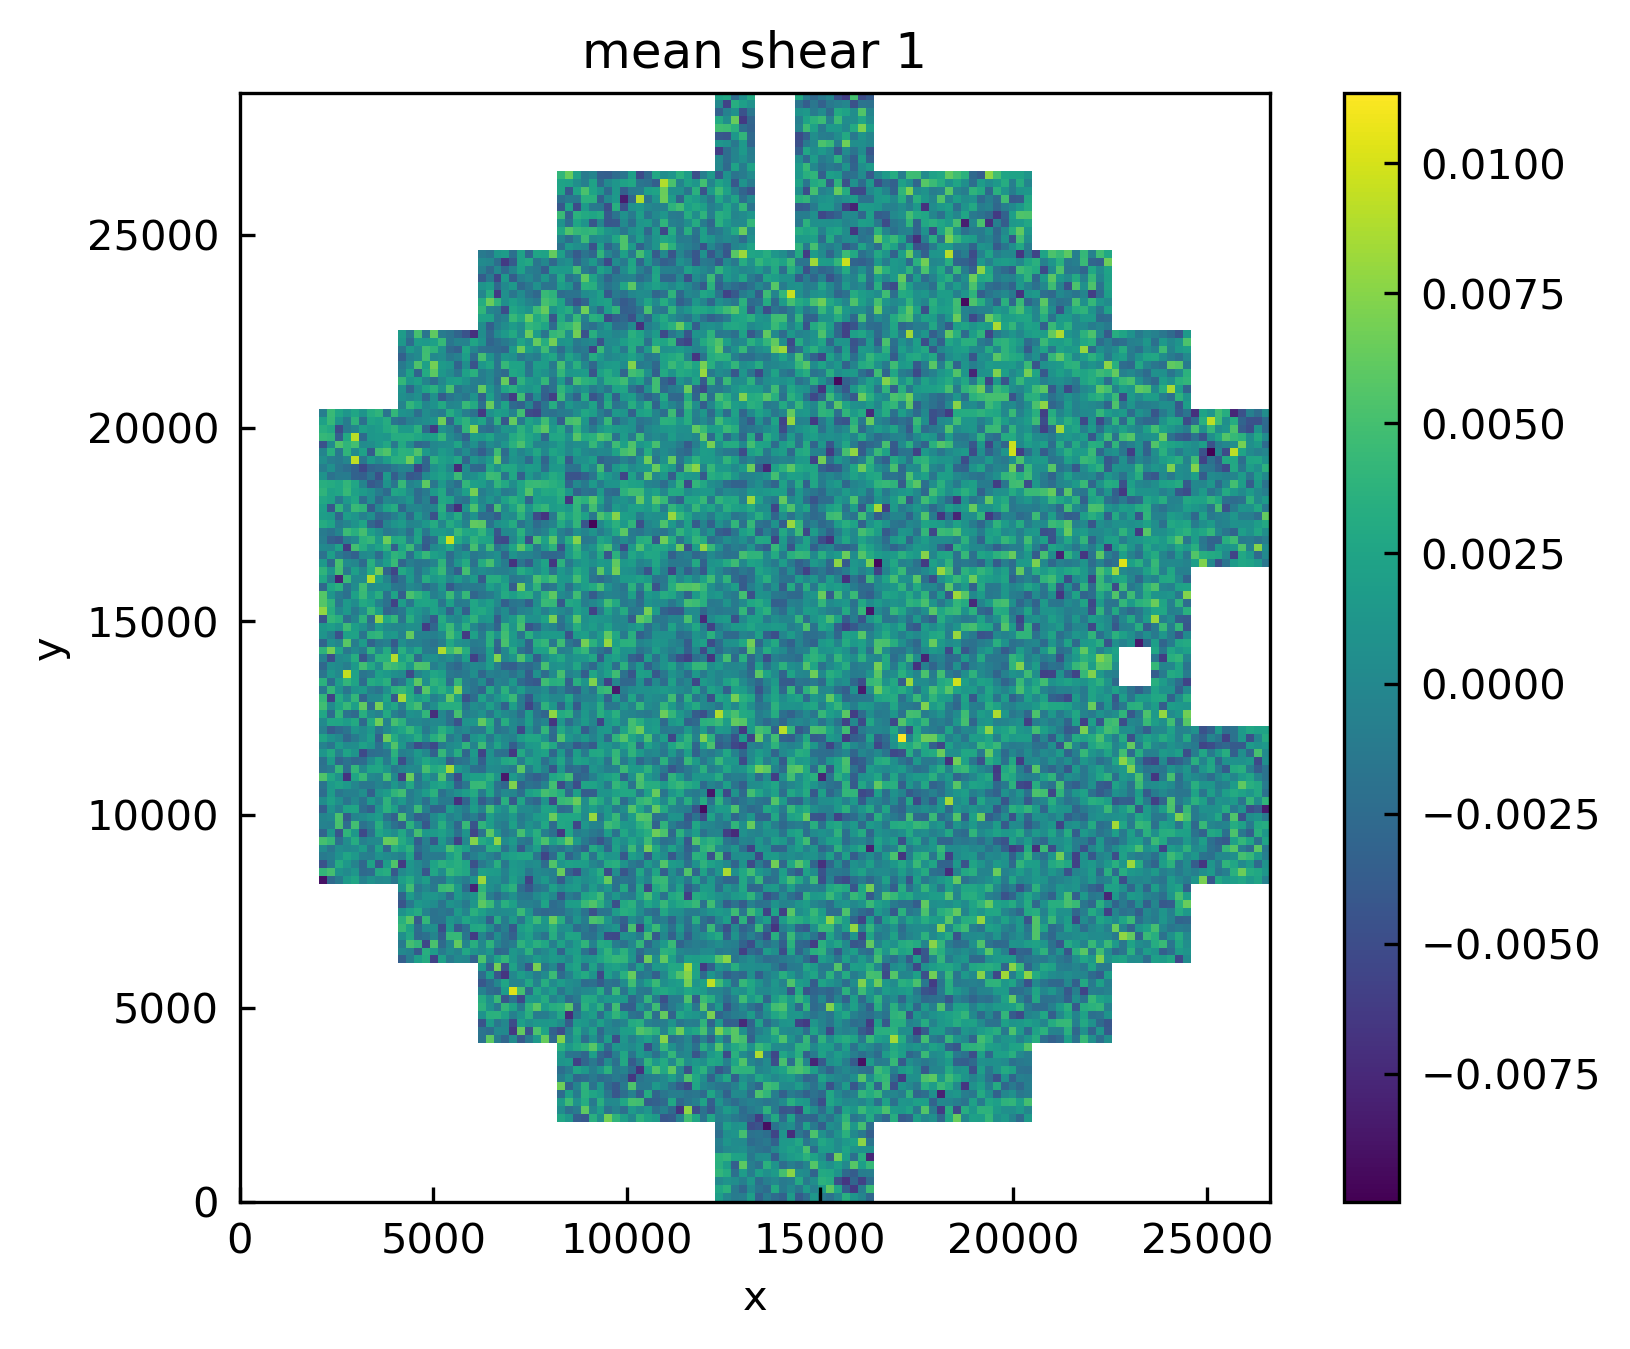

In [29]:
plt.imshow(shear1/Ncount,origin='lower',extent=[0,26625,0,28673])
plt.colorbar()
plt.title('mean shear 1')
plt.xlabel('x')
plt.ylabel('y')

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'y')

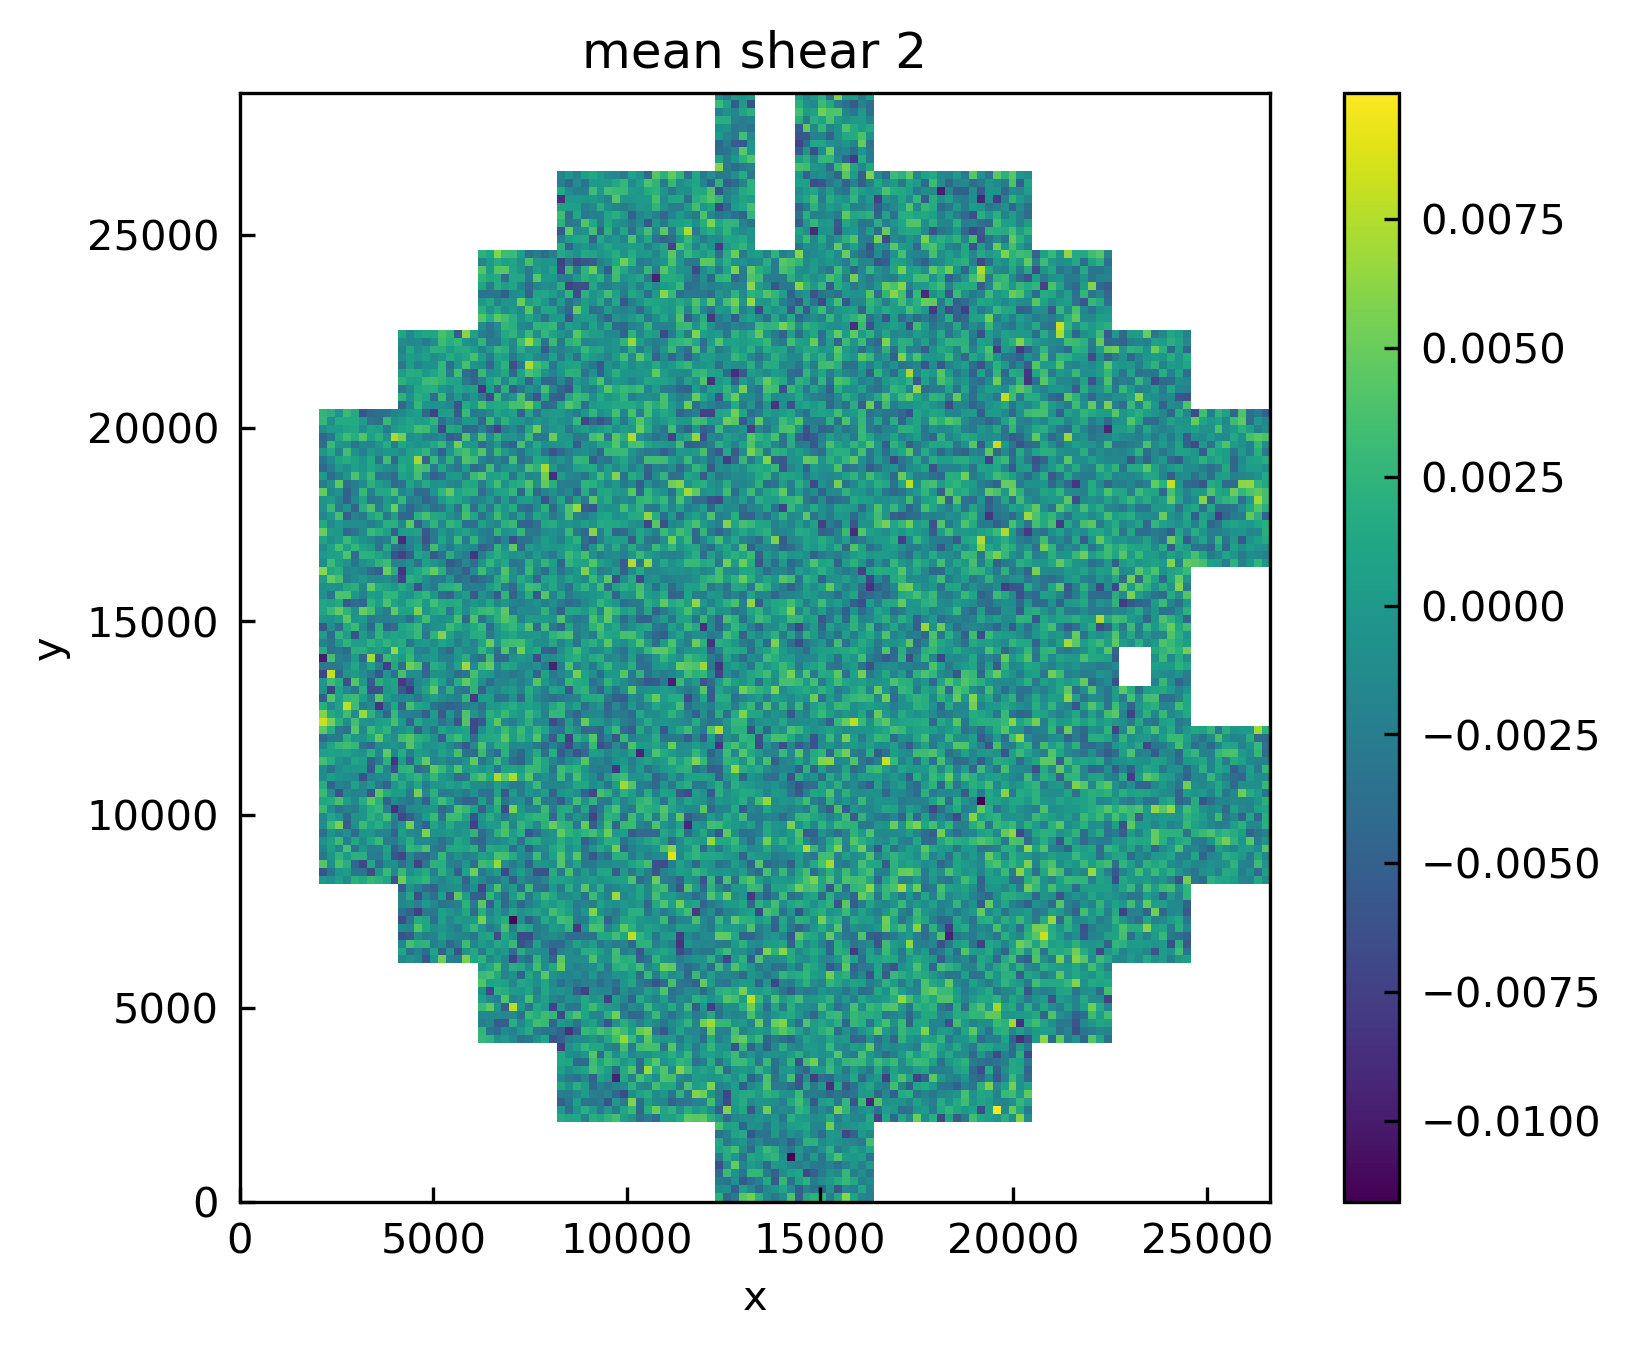

In [30]:
plt.imshow(shear2/Ncount,origin='lower',extent=[0,26625,0,28673])
plt.colorbar()
plt.title('mean shear 2')
plt.xlabel('x')
plt.ylabel('y')

### test calibration by patch

In [21]:
#new = fitsio.read(f'/project2/chihway/data/decade/shearcat_v1_test/{fnames[3]}')
from astropy.table import Table, hstack
from astropy.io import fits
#new = hstack([fitsio.read(f'/project2/chihway/data/decade/shearcat_v1_test/{fname}') for fname in fnames])

with fits.open(f'/project2/chihway/data/decade/shearcat_v1_test/{fnames[0]}') as hdul1:
    with fits.open(f'/project2/chihway/data/decade/shearcat_v1_test/{fnames[1]}') as hdul2:
        nrows1 = hdul1[1].data.shape[0]
        nrows2 = hdul2[1].data.shape[0]
        nrows = nrows1 + nrows2
        hdu = fits.BinTableHDU.from_columns(hdul1[1].columns, nrows=nrows)
        for colname in hdul1[1].columns.names:
            hdu.data[colname][nrows1:] = hdul2[1].data[colname]
        hdu.writeto('newtable.fits')


new = fitsio.read('newtable.fits')

mask0 = (~((new['mcal_T_noshear'][:]>2)*(new['mcal_s2n_noshear'][:]<30)))*(new['mcal_T_noshear'][:]<10)*(new['mcal_s2n_noshear'][:]<1000)*(new['mcal_s2n_noshear'][:]>10)*(new['mcal_T_ratio_noshear'][:]>0.5)
mask_1p = (~((new['mcal_T_1p'][:]>2)*(new['mcal_s2n_1p'][:]<30)))*(new['mcal_T_1p'][:]<10)*(new['mcal_s2n_1p'][:]<1000)*(new['mcal_s2n_1p'][:]>10)*(new['mcal_T_ratio_1p'][:]>0.5)
mask_1m = (~((new['mcal_T_1m'][:]>2)*(new['mcal_s2n_1m'][:]<30)))*(new['mcal_T_1m'][:]<10)*(new['mcal_s2n_1m'][:]<1000)*(new['mcal_s2n_1m'][:]>10)*(new['mcal_T_ratio_1m'][:]>0.5)
mask_2p = (~((new['mcal_T_2p'][:]>2)*(new['mcal_s2n_2p'][:]<30)))*(new['mcal_T_2p'][:]<10)*(new['mcal_s2n_2p'][:]<1000)*(new['mcal_s2n_2p'][:]>10)*(new['mcal_T_ratio_2p'][:]>0.5)
mask_2m = (~((new['mcal_T_2m'][:]>2)*(new['mcal_s2n_2m'][:]<30)))*(new['mcal_T_2m'][:]<10)*(new['mcal_s2n_2m'][:]<1000)*(new['mcal_s2n_2m'][:]>10)*(new['mcal_T_ratio_2m'][:]>0.5)

# calcualte metacalibration factors
dgamma = 2*0.01

# add weights to everything

print("DELVE")

R11  = (np.mean(new['mcal_g_1p'][:,0][mask0]) - np.mean(new['mcal_g_1m'][:,0][mask0]))/dgamma
R11s = (np.mean(new['mcal_g_noshear'][:,0][mask_1p]) - np.mean(new['mcal_g_noshear'][:,0][mask_1m]))/dgamma
R11tot = R11 + R11s
print('R11_g', R11, 'R11_s', R11s)
print('R11 tot', R11tot)

R22  = (np.mean(new['mcal_g_2p'][:,1][mask0]) - np.mean(new['mcal_g_2m'][:,1][mask0]))/dgamma
R22s = (np.mean(new['mcal_g_noshear'][:,1][mask_2p]) - np.mean(new['mcal_g_noshear'][:,1][mask_2m]))/dgamma
R22tot = R22 + R22s
print('R22_g', R22, 'R22_s', R22s)
print('R22 tot', R22tot)

print(len(new['mcal_g_2p'][:,1][mask0]))
print(new['mcal_g_2p'][:,1][mask0])

DELVE
R11_g 0.7326001431895306 R11_s 0.023316509396339787
R11 tot 0.7559166525858704
R22_g 0.6573668915904662 R22_s 0.0014811465619054723
R22 tot 0.6588480381523717
31013
[-0.32466607  0.20987213 -0.48707891 ... -0.03561088  0.1970319
  0.12360849]


### Stupid (slow) way of plotting shear

In [52]:
e1_s = new['mcal_g_noshear'][df0][:,0]/R11tot
e2_s = new['mcal_g_noshear'][df0][:,1]/R22tot
ccdnum_s = new['ccdnum'][df0]
x_exp_s = new['x_exp'][df0]
y_exp_s = new['y_exp'][df0]

%%time
x_focal_s = []
y_focal_s = []
for i in range(len(e1_s)):
    x_focal = np.ones((3,20))*(-9999)
    y_focal = np.ones((3,20))*(-9999)
    for color_ind in range(0,3): 
        coordmask = ccdnum_s[i][color_ind] != -9999
        offset_x, offset_y = corners[:,ccdnum_s[i][color_ind][coordmask]]
        x_focal[color_ind][coordmask] = x_exp_s[i][color_ind][coordmask] + offset_x
        y_focal[color_ind][coordmask] = y_exp_s[i][color_ind][coordmask] + offset_y
    x_focal_s.append(np.array(x_focal))
    y_focal_s.append(np.array(y_focal))
    
    
nbin = 50
x_bin = np.linspace(0,30000,nbin)
y_bin = np.linspace(0,30000,nbin)
shear1 = np.zeros((nbin,nbin))
shear2 = np.zeros((nbin,nbin))
count = np.zeros((nbin,nbin))


for i in range(len(e1_s)):
    e1 = e1_s[i]
    e2 = e2_s[i]
    for color_ind in range(0,3): 
        coordmask = ccdnum_s[i][color_ind] != -9999
        xs = x_focal_s[i][color_ind][coordmask]
        ys = y_focal_s[i][color_ind][coordmask]
        for x, y in zip(xs, ys):
            ind_x = np.searchsorted(x_bin,x)-1
            ind_y = np.searchsorted(y_bin,y)-1
            shear1[ind_x,ind_y] += e1
            shear2[ind_x,ind_y] += e2
            count[ind_x,ind_y] += 1
count[-1,-1]=np.nan

CPU times: user 2.69 s, sys: 11.3 ms, total: 2.7 s
Wall time: 2.7 s
